##### Copyright 2018 The TensorFlow Authors.



In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Mixed Precision Training of CNN

_Notebook originally contributed by: [Timothy Liu](https://github.com/tlkh)_

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/cifar10_mixed_precision.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/community/en/cifar10_mixed_precision.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

In this example, we will speed-up the training of a simple CNN with mixed precision. The CNN will perform image classification on the CIFAR10 dataset.

By using mixed precision, we can reduce the training time without a significant impact on classification accuracy. For example, using the NVIDIA Tesla T4 GPU on Google Colab, we can reduce the training time (using the same model and batch size) over 10 epochs from about 600 seconds to about 300 seconds, without sacrificing classification accuracy.

**How mixed precision works**

**Mixed precision** is the use of both float16 and float32 tensors when training a model.

Performing arithmetic operations in float16 takes advantage of the performance gains of using lower precision hardware (such as Tensor Cores). Due to the smaller representable range of float16, performing the entire training with float16 tensors can result in underflow and overflow errors.

However, *performing only certain arithmetic operations* in float16 results in performance gains when using compatible hardware accelerators, decreasing training time and reducing memory usage, typically without sacrificing model performance.

To learn more about mixed precision and how it works:

* [Overview of Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision)
* [NVIDIA Mixed Precision Training Documentation](https://docs.nvidia.com/deeplearning/sdk/mixed-precision-training/index.html)
* [NVIDIA Deep Learning Performance Guide](https://docs.nvidia.com/deeplearning/sdk/dl-performance-guide/index.html)
* [Information about NVIDIA Tensor Cores](https://developer.nvidia.com/tensor-cores)
* [Post on TensorFlow blog explaining Automatic Mixed Precision](https://medium.com/tensorflow/automatic-mixed-precision-in-tensorflow-for-faster-ai-training-on-nvidia-gpus-6033234b2540)

Do note that some of the resources above reference an older version of the mixed precision API (setting the `TF_ENABLE_AUTO_MIXED_PRECISION` environment variable). The method presented in this notebook is the current API used in TensorFlow 1.14 and newer.

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import time
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

Run some checks to ensure that prerequisites for this demo are met:

* TensorFlow version >= `1.14.0-rc0`
* NVIDIA Tensor Core GPU (Compute Capability >= `7.0`)

In [3]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True

print("TensorFlow version is", tf.__version__)

try:
    # check and assert TensorFlow >= 1.14
    tf_version_list = tf.__version__.split(".")
    if int(tf_version_list[0]) < 2:
        assert int(tf_version_list[1]) >= 14
except:
    print("TensorFlow 1.14.0 or newer is required.")
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
assert check_tensor_core_gpu_present() == True

TensorFlow version is 1.14.0-rc0
Tensor Core GPU Present: True


## Import the Dataset

Import the CIFAR10 image dataset from `tf.keras.datasets`

In [0]:
# The data, split between train and test sets

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

num_classes = np.max(y_train) + 1

# Convert class vectors to binary class matrices

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(height_shift_range=0.05,
                                                          horizontal_flip=True)

Preprocess the images by scaling the values from the range `0 ~ 255` to the range `0 ~ 1`

In [0]:
def normalize(ndarray):
    ndarray = ndarray.astype("float32")
    ndarray = ndarray/255.0
    return ndarray

x_train = normalize(x_train)
x_test = normalize(x_test)

## Define the Model

Define a reusable helper function to return a simple CNN

In [0]:
def create_model(num_classes=10):
    """
    Returns a simple CNN suitable for classifiying images from CIFAR10
    """
    # model parameters
    act = "relu"
    pad = "same"
    ini = "he_uniform"
    
    model = tf.keras.models.Sequential([
        Conv2D(128, (3, 3), activation=act, padding=pad, kernel_initializer=ini,
               input_shape=(32,32,3)),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(128, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        MaxPooling2D(pool_size=(4,4)),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation="softmax")
    ])

    return model

In [7]:
model = create_model(num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       5

## Training the Model

Train and benchmark the same model trained with and without mixed precision

In [0]:
# training parameters
BATCH_SIZE = 160
N_EPOCHS = 10
opt = tf.keras.optimizers.SGD(lr=0.003, momentum=0.7)

In [0]:
def train_model(mixed_precision, optimizer):
    """
    Trains a CNN to classify images on CIFAR10,
    and returns the training and classification performance
    
    Args:
        mixed_precision: `True` or `False`
        optimizer: An instance of `tf.keras.optimizers.Optimizer`
    """
    model = create_model(num_classes)

    if mixed_precision:
        optimizer = tf.train.experimental.enable_mixed_precision_graph_rewrite(optimizer)

    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    
    train_start = time.time()

    train_log = model.fit_generator(datagen.flow(x_train, y_train,
                                                 batch_size=BATCH_SIZE),
                                    epochs=N_EPOCHS,
                                    workers=2)

    train_end = time.time()

    score = model.evaluate(x_test, y_test)
    
    results = {"test_loss": score[0],
               "test_acc": score[1],
               "train_time": train_end-train_start,
               "train_log": train_log}
    
    return results

### Training without Mixed Precision

In [10]:
fp32_results = train_model(mixed_precision=False, optimizer=opt)

test_acc = round(fp32_results["test_acc"]*100, 1)
train_time = round(fp32_results["train_time"], 1)

print(test_acc, "% achieved in", train_time, "seconds")

Epoch 1/10


W0602 18:56:08.441979 139783656503168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


313/313 [==============================] - 63s 201ms/step - loss: 1.6342 - accuracy: 0.4123
Epoch 2/10
313/313 [==============================] - 58s 184ms/step - loss: 1.3105 - accuracy: 0.5334
Epoch 3/10
313/313 [==============================] - 58s 185ms/step - loss: 1.1586 - accuracy: 0.5900
Epoch 4/10
313/313 [==============================] - 58s 185ms/step - loss: 1.0376 - accuracy: 0.6315
Epoch 5/10
313/313 [==============================] - 58s 184ms/step - loss: 0.9457 - accuracy: 0.6659
Epoch 6/10
313/313 [==============================] - 58s 185ms/step - loss: 0.8646 - accuracy: 0.6973
Epoch 7/10
313/313 [==============================] - 58s 184ms/step - loss: 0.7982 - accuracy: 0.7206
Epoch 8/10
313/313 [==============================] - 58s 185ms/step - loss: 0.7493 - accuracy: 0.7393
Epoch 9/10
313/313 [==============================] - 58s 185ms/step - loss: 0.7037 - accuracy: 0.7537
Epoch 10/10
10000/10000 [==============================] - 4s 406us/sample - loss: 0

In [0]:
# to ensure accuracy of timing benchmark
# we give the GPU 30 seconds to cool down

tf.keras.backend.clear_session()
time.sleep(30)

### Training with Mixed Precision

In [12]:
mp_results = train_model(mixed_precision=True, optimizer=opt)

test_acc = round(mp_results["test_acc"]*100, 1)
train_time = round(mp_results["train_time"], 1)

print(test_acc, "% achieved in", train_time, "seconds")

Epoch 1/10
313/313 [==============================] - 34s 107ms/step - loss: 1.6497 - accuracy: 0.4052
Epoch 2/10
313/313 [==============================] - 28s 91ms/step - loss: 1.3323 - accuracy: 0.5252
Epoch 3/10
313/313 [==============================] - 29s 92ms/step - loss: 1.1758 - accuracy: 0.5820
Epoch 4/10
313/313 [==============================] - 29s 92ms/step - loss: 1.0585 - accuracy: 0.6251
Epoch 5/10
313/313 [==============================] - 29s 93ms/step - loss: 0.9583 - accuracy: 0.6609
Epoch 6/10
313/313 [==============================] - 29s 93ms/step - loss: 0.8884 - accuracy: 0.6856
Epoch 7/10
313/313 [==============================] - 29s 92ms/step - loss: 0.8256 - accuracy: 0.7100
Epoch 8/10
313/313 [==============================] - 29s 92ms/step - loss: 0.7830 - accuracy: 0.7246
Epoch 9/10
313/313 [==============================] - 29s 93ms/step - loss: 0.7333 - accuracy: 0.7446
Epoch 10/10
10000/10000 [==============================] - 3s 285us/sample - loss

### Evaluate the Model Performance

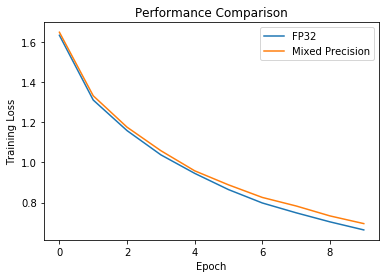

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fp32_results["train_log"].history["loss"], label="FP32")
plt.plot(mp_results["train_log"].history["loss"], label="Mixed Precision")
plt.title("Performance Comparison")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [14]:
speed_up = round(100 * fp32_results["train_time"]/mp_results["train_time"], 1)

print("Total speed-up:", speed_up, "%")

Total speed-up: 198.7 %


## Conclusions

* Mixed Precision training provides a significant speed-up over FP32 (single-precision) training
* Switch to using mixed precision by wrapping a `tf.keras.optimizers` Optimizer in `tf.train.experimental.enable_mixed_precision_graph_rewrite()`
